## Minimal LogisticRegressionWithError class
J. Landy, EFvaDB, 2017

Two cells:  1)  Class code, 2) Application to Iris data set.  Requires sklearn, matplotlib, and numpy.

Accompanying post here:  www.efavdb.com/logistic-regression


In [1]:
from sklearn.linear_model import LogisticRegression
import numpy as np


class LogisticRegressionWithError(LogisticRegression):
    """
    Minimal wrapper of SKLearn's LogisticRegression class
    returning confidence intervals within the predict_proba
    method.  Works with binary class system only.
    """
    def __init__(self, **kwargs):
        """
        parameters
        ----------
        See sklearn documentation for full list.  Two of note
        listed here.
        
        fit_intercept : bool
            Default is True.  Setting to False will create
            fit with no intercept added.
            
        C : numeric
            The inverse L2 regularization strength.  Default
            is 1.0.  Increasing C decreases strength of the
            regularization.
        """
        super(self.__class__, self).__init__(**kwargs)
      
    def _logistic_transform(self, x):
        """
        Returns Logistic Transform of passed logit.
        See (1) of post.
        """
        return 1.0 / (1 + np.exp(-x))
    
    def _check_binary(self, y):
        """
        Ensure working with binary data.
        """
        if len(set(y)) != 2:
            raise ValueError('Class only supports binary data.')
    
    def _get_cov(self, X):
        """
        Evaluate the parameter covariance matrix.
        See (1), (6), and (8) of post.  Here, we take into account
        effect of L2 regularization of covariance matrix.
        """
        X = X.copy()
        weights = [p[0] * p[1] for p in 
                   super(self.__class__, self).predict_proba(X)]
        if self.fit_intercept:
            X = np.hstack((X, np.ones(len(X)).reshape([-1, 1])))
        second_partials = [
            np.outer(x, x) * weights[i] for i, x in enumerate(X)]
        inv_cov = np.sum(second_partials, axis=0) \
            + np.identity(X.shape[1]) / self.C
        self.cov = np.linalg.inv(inv_cov)
   
    def _get_interval(self, x, z):
        """
        Return interval for passed test point.
        See (1), (11), and (12) of post.
        """
        x = np.array(x).copy()
        if self.fit_intercept:
            x = np.concatenate((x, np.array([1])))
        # get point estimate for logit, std.
        coefficients = np.hstack((self.coef_[0], self.intercept_))
        logit = np.dot(coefficients, x)
        logit_std = np.sqrt(np.dot(x, np.dot(self.cov, x)))
        # evaluate interval for class one probability, return
        min_bound = self._logistic_transform(logit - z * logit_std)
        max_bound = self._logistic_transform(logit + z * logit_std)
        return min_bound, max_bound

    def fit(self, X, y):
        """
        Fit model to data.
        
        parameters
        ----------
        X : np.array
            shape : (n_examples, n_features)
            Feature array for training set
        
        y : np.array
            shape : (n_examples)
            Label array for training set.
        """
        super(self.__class__, self).fit(X, y)
        self._check_binary(y)
        self._get_cov(X)
            
    def predict_proba(self, X, z=2):
        """
        Return interval for class one probability point
        estimates and intervals for passed test points.
        Note:  Formulae applied assume asymptotic limit.
        
        parameters
        ----------
        X : np.array
            shape : (n_example, n_features)
            Test point array
        
        z : numeric type, should be non-negative
            z-score for interval to be returned.  Eg,
            if z=2, you get a ~95% confidence interval.
        """
        point_estimate = super(
            self.__class__, self).predict_proba(X).ravel()[1]
        intervals = np.array(
            [self._get_interval(x, z) for x in X]).ravel()
        return point_estimate, intervals
        

Populating the interactive namespace from numpy and matplotlib


(0, 1)

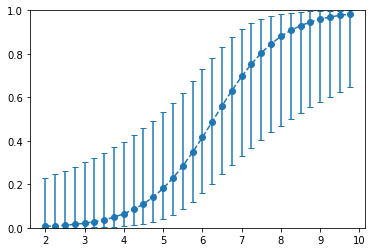

In [2]:
# Load Iris data set, take cut through parameter
# space and plot point estimate / error bars.
%pylab inline
from sklearn import datasets
import numpy as np
iris = datasets.load_iris()

X = iris.data
y = np.array([(i==1)*1 for i in iris.target])

model = LogisticRegressionWithError(C=10.0)
model.fit(X, y)

points = []
intervals = []
x_array = np.arange(2, 10, 0.25)
for i in x_array:
    x = [[i, 3, i, 2]]
    p, i = model.predict_proba(x, z=2)
    points.append(p)
    intervals.append(i)
    
y_error_lower = [p - i[0] for p, i in zip(points, intervals)]
y_error_upper = [i[1] - p for p, i in zip(points, intervals)]

# Plot
fig = plt.figure()  # create a figure object
ax = fig.add_subplot(1, 1, 1)
ax.errorbar(x_array, points, yerr=[y_error_lower, y_error_upper], fmt='--o', capsize=3,)
ax.set_ylim([0,1])